In [1]:
__author__ = "Jon Ball"
__version__ = "Autumn 2022"

In [2]:
!python --version

In [3]:
from eric_parser import ERICparser

from nltk.tokenize import word_tokenize, sent_tokenize
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from collections import defaultdict
import time
import os
import re

# Table of Contents

1. [Loading and Visualizing ERIC data](#vis)
2. [Data Cleaning](#clean)
3. [Saving ERIC inputs for topic modeling](#txt)

In [4]:
parser = ERICparser()

In [5]:
paths_to_xml = [] # A list of file paths for each yearly .xml file provided by ERIC (https://eric.ed.gov/?download)
for path, dirs, files in os.walk(os.path.join("data")):
    for file in files:
        if re.search("\d{4}.xml", file):
            paths_to_xml.append(os.path.join(path, file))

In [6]:
total_record_count = 0
yeard = {}
typed = defaultdict(int)
for path in tqdm(paths_to_xml): # For each year's file
    # Parse the .xml file
    parser.parse(path)
    # Add to total and year record counts
    total_record_count += parser.num_records
    yeard[path[-8:-4]] = parser.num_records
    # Create a list of all non-null record types
    td = parser.data_fields(["type"], flatten=True)
    for t in td["type"]:
        typed[t] += 1

print(f"ERIC indexes {total_record_count} item records in total.")

100%|███████████████████████████████████████████| 57/57 [01:27<00:00,  1.53s/it]

ERIC indexes 1876097 item records in total.


In [7]:
yearDF = pd.DataFrame(
    {"Year": list(yeard.keys()), "Number of ERIC records": list(yeard.values())}
).sort_values(by="Year")

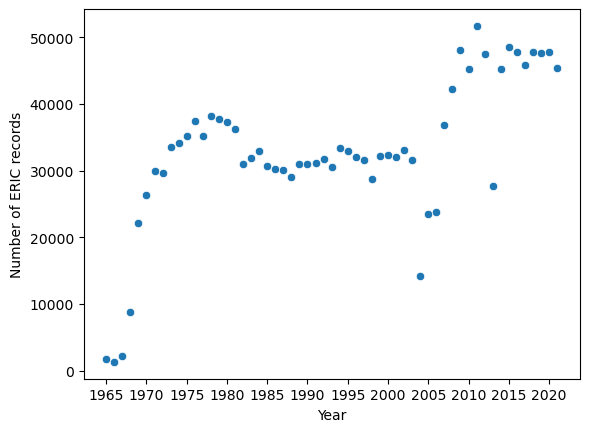

In [8]:
ax = sns.scatterplot(data=yearDF, x="Year", y="Number of ERIC records")
ax.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55])
ax.set_xticklabels(["1965","1970","1975","1980","1985","1990","1995","2000","2005","2010","2015","2020"])
plt.show()

Many of the records represented in the plot *above*, specifically those from 1965-74, do **not** have `"dc:type"` metadata. Additionally, many of the records feature multiple types. <br><br> As such, the plot *below* does not assume that each record corresponds to one and only one type. The distribution of types may nonetheless be accurate.

In [9]:
typeDF = pd.DataFrame(
    {"Record type": typed.keys(), "Number of ERIC records": typed.values()}
).sort_values(by="Number of ERIC records", ascending = False)

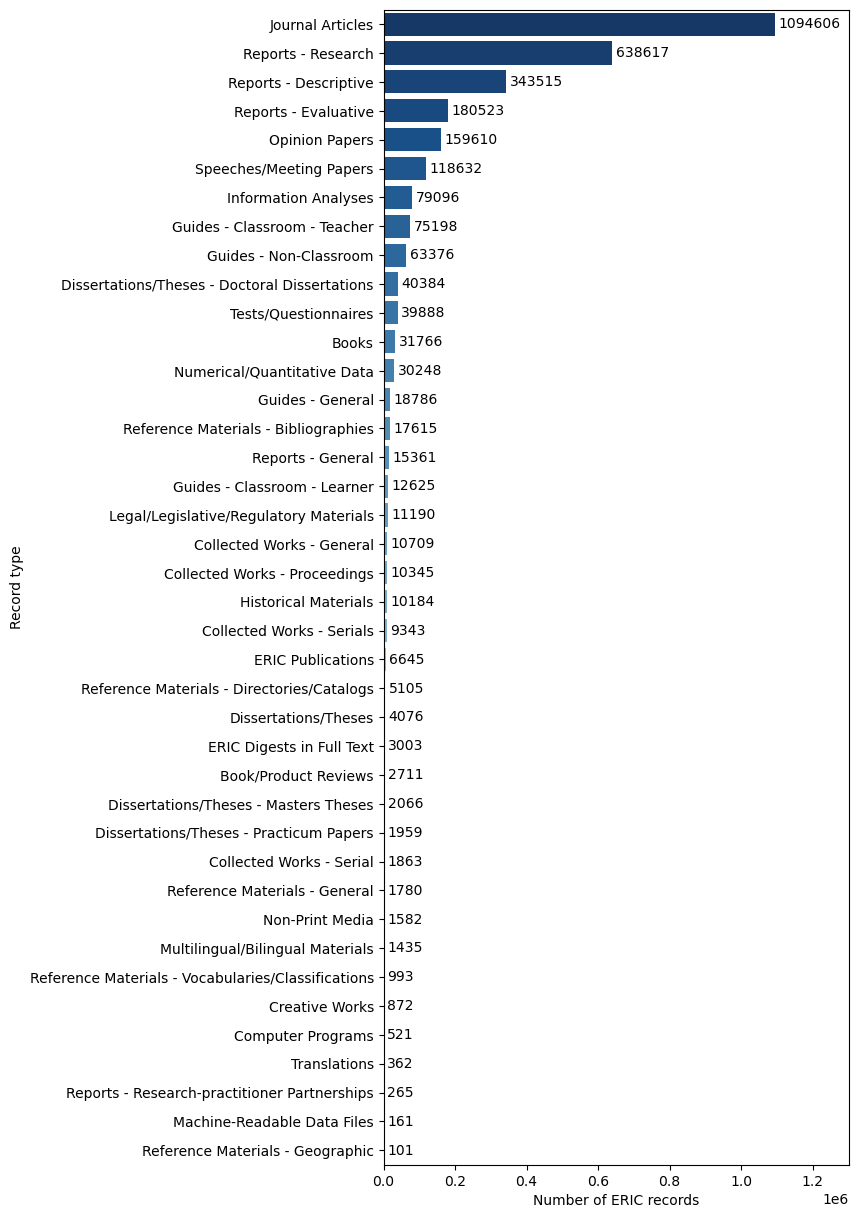

In [10]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(data=typeDF, x="Number of ERIC records", y="Record type", palette="Blues_r")
plt.xlim(right=1300000)
for p in ax.patches:
    ax.annotate(text=round(p.get_width()), xy=(p.get_width() + 10000, p.get_y() + p.get_height() / 2), 
                ha="left", va="center")

### Let's check out a single example of a "title" and "description" for a record:

In [11]:
path_to_xml = os.path.join("data", "eric2020-2021", "eric2021.xml")
parser.parse(path_to_xml)
print(next(parser.iter_field("title")), 
      "\n\n",
      next(parser.iter_field("description")))

Advanced Course Enrollment and Performance among English Learner Students in Washington State. REL 2017-187 

 Taking advanced high school courses (for example, honors, Advanced Placement, and dual-credit courses that offer college credits in high school) can help prepare students for postsecondary education and careers. English learner students, however, face unique obstacles to taking advanced courses because they must divide their time between acquiring English proficiency and learning academic content. This descriptive study examines patterns in advanced coursetaking among current and former English learner students and never-English learner students in Washington state. Using state data about students enrolled in Washington public schools between 2009/10 and 2012/13, this study analyzed advanced course enrollment patterns and performance among the groups of students. It finds that where students attend school and their academic preparation account for much of the difference in adv

In [12]:
print(f"ERIC indexes {parser.num_records} records of items published in 2021 alone. Plenty of text for an NLP project!")

ERIC indexes 45435 records of items published in 2021 alone. Plenty of text for an NLP project!


Now let's do the same for a much older record:

In [13]:
path_to_xml = os.path.join("data", "eric1980-1989", "eric1980.xml")
parser.parse(path_to_xml)

In [14]:
print(next(parser.iter_field("title")), 
      "\n\n",
      next(parser.iter_field("description")))

Resources in Education (RIE). Volume 15, Number 1. 

 Resources in Education (RIE) is a monthly abstract journal which announces (catalogs, indexes, abstracts) documents of interest to the educational community (including researchers, teachers, students, school board members, school administrators, counselors, etc.). Each issue announces approximately 1,500 documents and provides indexes by Subject, Personal Author, Institution, Publication Type, and ERIC Clearinghouse Number. This special Computer Output Microfiche (COM) edition is prepared directly from the ERIC magnetic tape data base prior to publication of the printed journal and therefore is lacking the cover and other regular introductory and advertising matter contained in the printed journal. The first accession in each issue of RIE is the issue itself. In this way, the  monthly microfiche collection for each issue is immediately preceded by a microfiche index to that collection. This practice began with the RIE issue for MAY 

The title is not an actual title. This appears to be a record for an entire journal. There are some acronyms at the end of the description as well, which need to be removed.

In [15]:
sent_tokenize(next(parser.iter_field("description")))

['Resources in Education (RIE) is a monthly abstract journal which announces (catalogs, indexes, abstracts) documents of interest to the educational community (including researchers, teachers, students, school board members, school administrators, counselors, etc.).',
 'Each issue announces approximately 1,500 documents and provides indexes by Subject, Personal Author, Institution, Publication Type, and ERIC Clearinghouse Number.',
 'This special Computer Output Microfiche (COM) edition is prepared directly from the ERIC magnetic tape data base prior to publication of the printed journal and therefore is lacking the cover and other regular introductory and advertising matter contained in the printed journal.',
 'The first accession in each issue of RIE is the issue itself.',
 'In this way, the  monthly microfiche collection for each issue is immediately preceded by a microfiche index to that collection.',
 'This practice began with the RIE issue for MAY 1979.',
 '(LRS/WTB)']

NLTK's sentence tokenizer will make it easier to cut off the parenthetical citations at the end of each description.<br>(The parentheticals at the end of each description are the initials of ERIC staff who entered the metadata.)<br>

Finally, iteratively write "documents" to a large .txt file. Each doc is either a record title, or a single sentence from a split description. Each doc is written on a new line so as to be easily readable/streamable.

In [16]:
path_to_txt = os.path.join("data", "eric_docs.txt")

In [17]:
num_docs = 0
with open(path_to_txt, "w") as outfile:
    
    for xml_path in tqdm(paths_to_xml):
        parser.parse(xml_path)
        
        for title in parser.iter_field("title"):
            outfile.write("%s\n" % (title,)) # Write titles to eric_docs.txt
            num_docs += 1
        for description in parser.iter_field("description"):
            docs = sent_tokenize(description)
            # Remove parenthetical citations at the end of each description
            docs = [d for d in docs if not re.search(r"^\(.+\)$", d)]
            for doc in docs:
                outfile.write("%s\n" % (doc,)) # Write sentences to eric_docs.txt
                num_docs += 1

100%|███████████████████████████████████████████| 57/57 [05:10<00:00,  5.45s/it]


In [18]:
print(f"{num_docs} docs saved as inputs for fastText. Each doc is title or sentence describing an ERIC item record.")

11367494 docs saved as inputs for fastText. Each doc is title or sentence describing an ERIC item record.


In [19]:
%%time

num_toks = 0
with open(path_to_txt, "r") as infile:
    for line in infile:
        num_toks += len(word_tokenize(line))

CPU times: user 17min 46s, sys: 3.25 s, total: 17min 49s
Wall time: 17min 50s


In [20]:
print(f"{num_toks} tokens saved as inputs for fastText.")

286348702 tokens saved as inputs for fastText.
